# Time Series Forecasting Using Hybrid Quantum-Classical Models

## Project Description

The goal of this project is to develop a time series forecasting model combining classical machine learning and quantum circuits. The aim is to explore how quantum circuits can improve predictive performance of classical models, be it via feature extraction, temporal pattern recognition, or sequence encoding.

## Outline

This Jupyter notebook is structured as follows.

1. **Data:**
    - Acquire a real-world time series dataset.
    - Perform preprocessing: normalization, scaling, windowing.
    - Create training, validation, and test sets.
2. **Classical Model:**
    - Create a baseline classical model.
    - Train the classical model on the dataset.
3. **Hybrid Model:**
    - Create a hybrid quantum-classical model comparable to the classical model used earlier.
    - Train the hybrid model on the dataset.
4. **Evaluation and Comparison:**
    - Evaluate the classical and the hybrid model on the dataset using standard time series forecasting metrics.
    - Compare the models' performance.
5. **Summary and Conclusion:**
    - Summarize results, key insights, challenges faced, possible improvements.
    - Conclude if enhancing a classical model with quantum circuits gave an advantage on the chosen dataset.

## Global Parameters

In [1]:
# Whether we work in colab environment or locally
ENV_COLAB = True

# Whether to mount Google Drive in Colab
MOUNT_GOOGLE_DRIVE = True

# Mounting path for Google Drive in Colab
DRIVE_MOUNT_PATH = '/content/drive'

# Whether to download dataset or load it from file
USE_PANDAS_DATASET = True

# Path to dataset in pandas
DATASET_PANDAS_PATH = 'hf://datasets/chrisaydat/applestockpricehistory/AAPL.csv'

# Path to dataset in Colab
DATASET_COLAB_PATH = '/content/drive/MyDrive/Colab Notebooks/qml-time-series/data/AAPL.csv'

# Path to dataset
DATASET_LOCAL_PATH = './data/AAPL.csv'

# Path to project's root folder
PROJECT_PATH = '/content/drive/MyDrive/Colab Notebooks/qml-time-series'

# Default size of matplotlib figures
DEFAULT_FIG_SIZE = (16, 9)

# Whether to load models
LOAD_MODELS = False

## Packages

Install Tensorflow and TensorflowQuantum.

In [2]:
!pip install --upgrade pip
!pip install tensorflow==2.15.0
!pip install --upgrade tensorflow-quantum

  Using cached protobuf-4.25.8-cp37-abi3-manylinux2014_x86_64.whl.metadata (541 bytes)
Using cached protobuf-4.25.8-cp37-abi3-manylinux2014_x86_64.whl (294 kB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.5
    Uninstalling protobuf-5.29.5:
      Successfully uninstalled protobuf-5.29.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-text 2.18.1 requires tensorflow<2.19,>=2.18.0, but you have tensorflow 2.15.0 which is incompatible.
ydf 0.12.0 requires protobuf<6.0.0,>=5.29.1, but you have protobuf 4.25.8 which is incompatible.
grpcio-status 1.71.0 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 4.25.8 which is incompatible.
tf-keras 2.18.0 requires tensorflow<2.19,>=2.18, but you have tensorflow 2.15.0 which is incompatible.
tensorflow-decision-forests 1.11.0 requires tensorflow==2.18.0, but you have tenso

  Using cached protobuf-5.29.5-cp38-abi3-manylinux2014_x86_64.whl.metadata (592 bytes)
Using cached protobuf-5.29.5-cp38-abi3-manylinux2014_x86_64.whl (319 kB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.8
    Uninstalling protobuf-4.25.8:
      Successfully uninstalled protobuf-4.25.8
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.20.3, but you have protobuf 5.29.5 which is incompatible.
tensorflow-text 2.18.1 requires tensorflow<2.19,>=2.18.0, but you have tensorflow 2.15.0 which is incompatible.
tf-keras 2.18.0 requires tensorflow<2.19,>=2.18, but you have tensorflow 2.15.0 which is incompatible.
tensorflow-decision-forests 1.11.0 requires tensorflow==2.18.0, but you have tensorflow 2.15.0 which is incompatible.


Import the required packages.

In [3]:
import tensorflow as tf  # for ML
import tensorflow_quantum as tfq  # for QML

import cirq  # for quantum circuits
import collections  # for data containers
import numpy as np  # for manipulating data
import pandas as pd  # for storing data
import seaborn as sns  # for visualizing statistical data
import sympy  # for symbolic math

import sklearn as skl  # for preprocessing data

import matplotlib.pyplot as plt  # for drawing plots
%matplotlib inline
from cirq.contrib.svg import SVGCircuit  # for drawing circuits

import dataclasses  # for defining dataclasses
import textwrap  # for processing whitespace in docstrings
import pickle  # for saving and loading data

import os  # for file system operations
from typing import Self  # for type annotations

In [4]:
# Workaround to suppress warnings from matplotlib not finding Arial font
import logging
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)

## Data

### Load Raw Data

In [5]:
if USE_PANDAS_DATASET:
    # Load dataset from pandas
    data = pd.read_csv(DATASET_PANDAS_PATH)
elif ENV_COLAB:
    # Load dataset from file in Colab
    if MOUNT_GOOGLE_DRIVE:
        # Mount Google drive if it is not mounted via graphical UI
        from google.colab import drive
        drive.mount(DRIVE_MOUNT_PATH)

    # Load dataset
    data = pd.read_csv(DATASET_COLAB_PATH)
else:
    # Load dataset from local file
    data = pd.read_csv(DATASET_LOCAL_PATH)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [6]:
# Convert dates to datetime values
data['Date'] = pd.to_datetime(data['Date'])

# Sort by date
data = data.sort_values(by='Date', ascending=True)
# data.set_index('Date', inplace=True)  # if desired, use dates as indices

In [7]:
# Check first several data entries
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-12-12,0.128348,0.128906,0.128348,0.128348,0.099722,469033600
1,1980-12-15,0.122210,0.122210,0.121652,0.121652,0.094519,175884800
2,1980-12-16,0.113281,0.113281,0.112723,0.112723,0.087582,105728000
3,1980-12-17,0.115513,0.116071,0.115513,0.115513,0.089749,86441600
4,1980-12-18,0.118862,0.119420,0.118862,0.118862,0.092351,73449600


In [8]:
# Check information of pandas dataframe
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10665 entries, 0 to 10664
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       10665 non-null  datetime64[ns]
 1   Open       10665 non-null  float64       
 2   High       10665 non-null  float64       
 3   Low        10665 non-null  float64       
 4   Close      10665 non-null  float64       
 5   Adj Close  10665 non-null  float64       
 6   Volume     10665 non-null  int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 583.4 KB


In [9]:
# Specify columns containing features and target label
feature_cols = ['Open', 'High', 'Low', 'Adj Close', 'Volume']
label_col = 'Close'

# Create list of all used columns
used_cols = feature_cols + [label_col]

### Visualize Raw Data

#### Line Plots

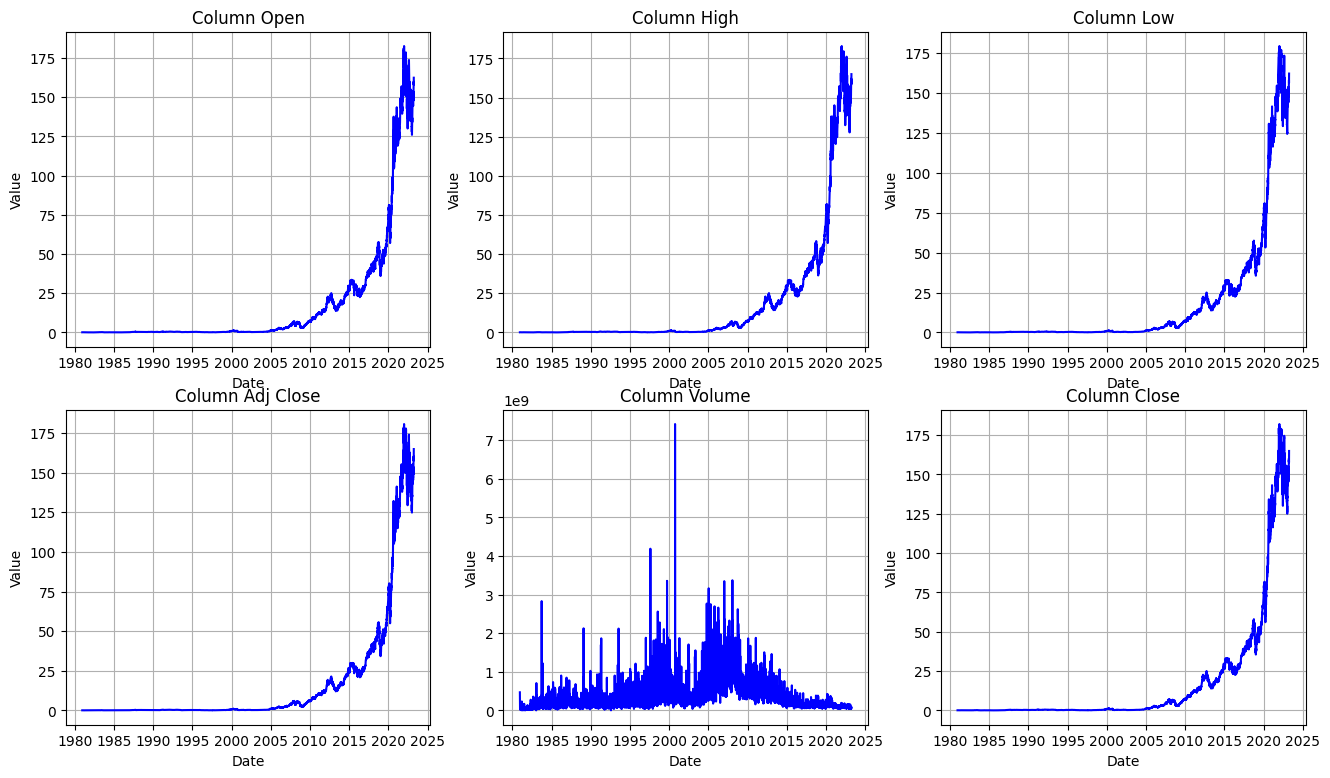

In [10]:
# Create plot figure
fig = plt.figure(figsize=DEFAULT_FIG_SIZE)

for i, col in enumerate(used_cols, 1):
    # Create subplot on i-th position in 2 x 3 grid
    ax = plt.subplot(2, 3, i)

    # Plot column data against date
    plt.plot(data['Date'], data[col], linestyle='-', color='b')

    # Set title and axis labels
    plt.title(f'Column {col}')
    plt.xlabel('Date')
    plt.ylabel('Value')

    # Display grid for readability
    plt.grid(True)

# Display plot
plt.show()

#### Box Plots

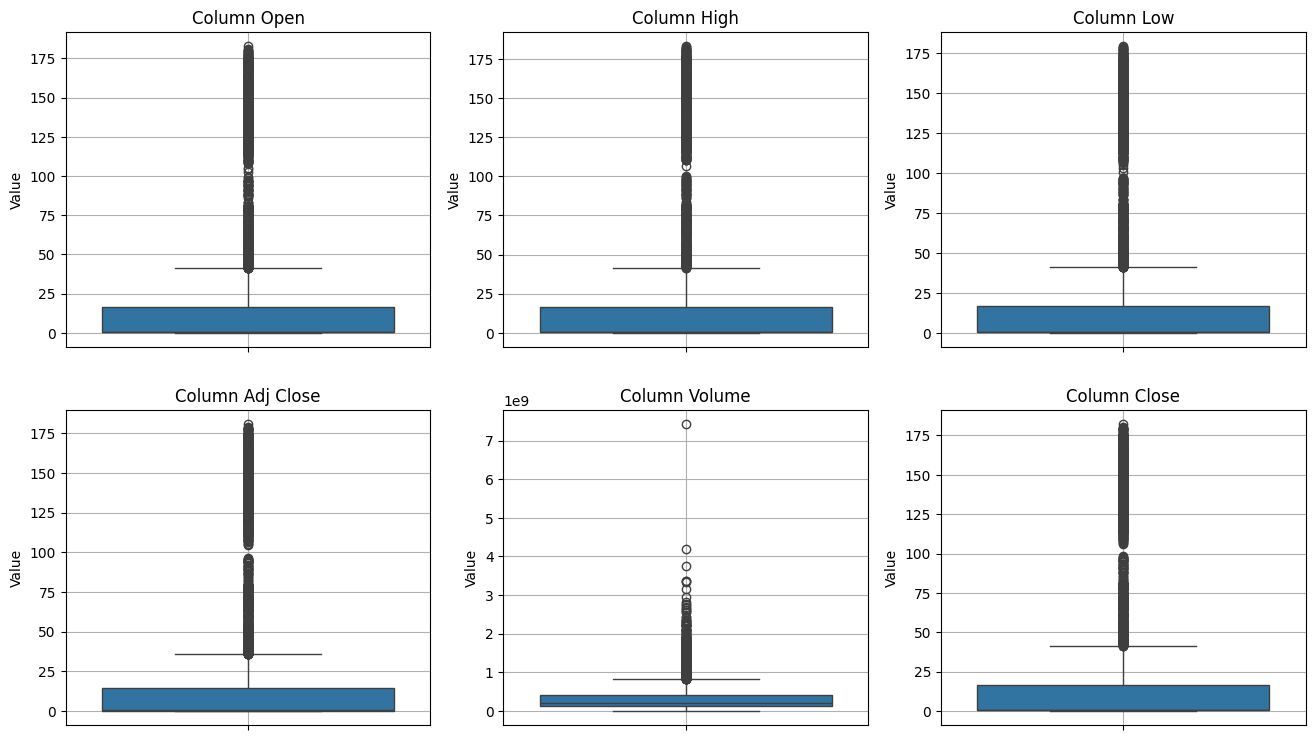

In [11]:
# Create plot figure
fig = plt.figure(figsize=DEFAULT_FIG_SIZE)

for i, col in enumerate(used_cols, 1):
    # Create subplot on i-th position in 2 x 3 grid
    plt.subplot(2, 3, i)

    # Plot column data as box plot
    ax = sns.boxplot(data[col])
    ax.set(xlabel=None)

    # Set title and axis labels
    plt.title(f'Column {col}')
    plt.xlabel(None)
    plt.ylabel('Value')

    # Display grid for readability
    plt.grid(True)

# Display plot
plt.show()

#### Covariance Plot

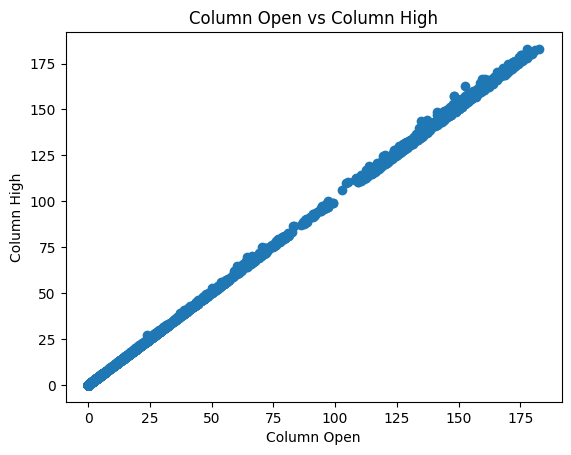

In [12]:
# Plot 'Open' column vs 'High' column as scatter plot
plt.scatter(data=data, x='Open', y='High')

# Set title and axis labels
plt.title('Column Open vs Column High')
plt.xlabel('Column Open')
plt.ylabel('Column High')

# Display plot
plt.show()

#### Frequency Analysis

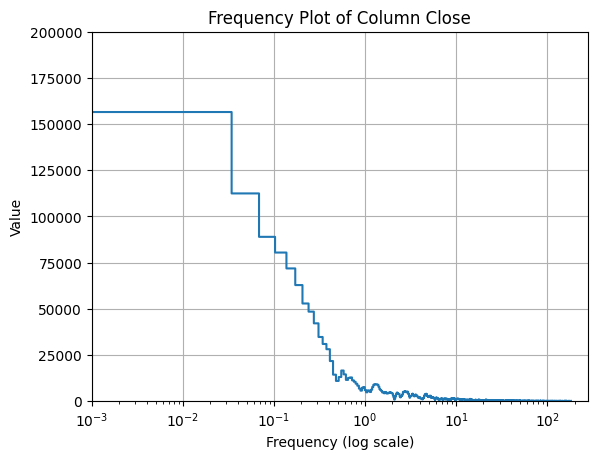

In [13]:
# Compute fast Fourier transform
fft = tf.signal.rfft(data[label_col])

# Compute frequency values
days_per_year = 365.2524
f_per_year = np.arange(0, len(fft)) / (len(data[label_col]) / days_per_year)

# Plot frequency graph in log scale
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 200000)
plt.xlim([0.001, max(plt.xlim())])

# Set title and axis labels
plt.title(f'Frequency Plot of Column {label_col}')
plt.xlabel('Frequency (log scale)')
plt.ylabel('Value')

# Display grid for readability
plt.grid(True)

# Display plot
plt.show()

#### Bonus: Growth Rate Plots

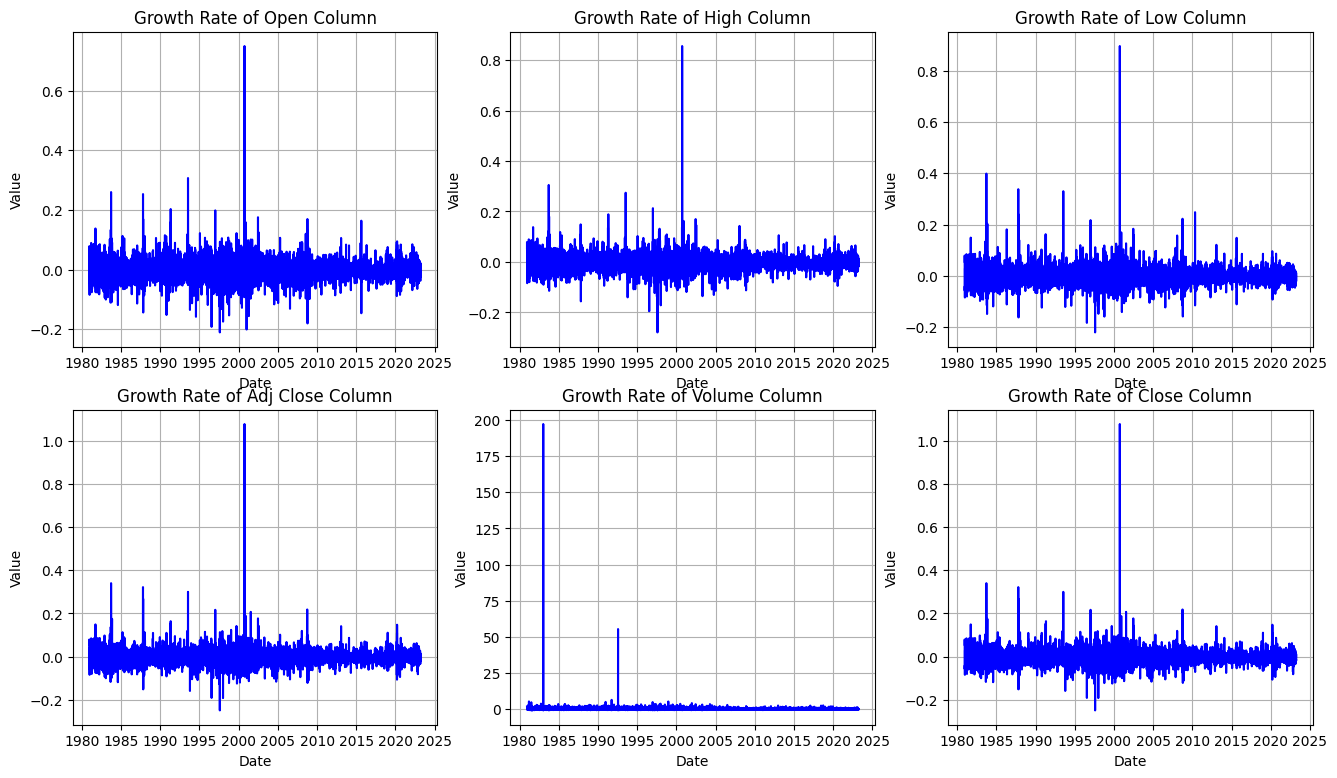

In [14]:
# Create plot figure
fig = plt.figure(figsize=DEFAULT_FIG_SIZE)

for i, col in enumerate(used_cols, 1):
    # Create subplot on i-th position in 2 x 3 grid
    plt.subplot(2, 3, i)

    # Compute growth rate
    growth_rate = (data[col].shift(1) - data[col]) / data[col]

    # Plot growth rate against date
    plt.plot(data['Date'], growth_rate, linestyle='-', color='b')

    # Set title and axis labels
    plt.title(f'Growth Rate of {col} Column')
    plt.xlabel('Date')
    plt.ylabel('Value')

    # Display grid for readability
    plt.grid(True)

# Display plot
plt.show()

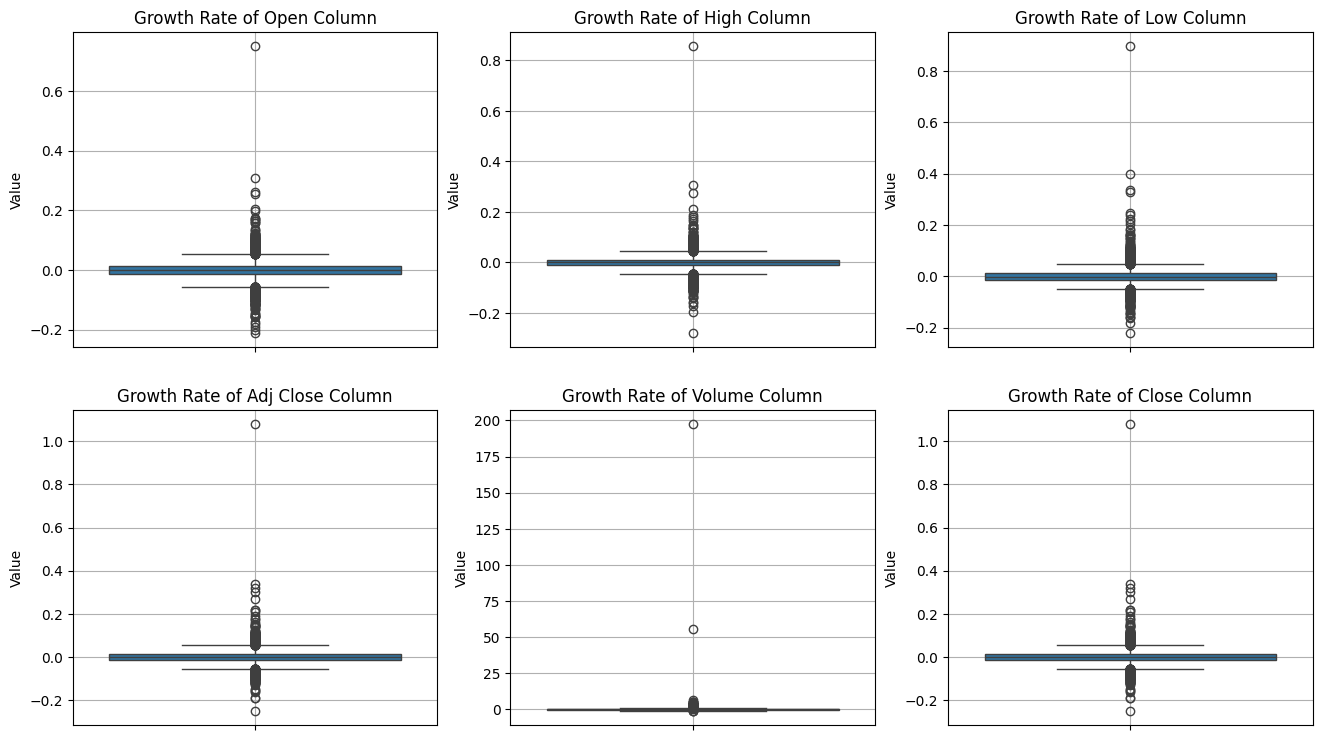

In [15]:
# Create plot figure
fig = plt.figure(figsize=DEFAULT_FIG_SIZE)

for i, col in enumerate(used_cols, 1):
    # Create subplot on i-th position in 2 x 3 grid
    plt.subplot(2, 3, i)

    # Compute growth rate
    growth_rate = (data[col].shift(1) - data[col]) / data[col]

    # Plot column data as box plot
    ax = sns.boxplot(growth_rate)
    ax.set(xlabel=None)

    # Set title and axis labels
    plt.title(f'Growth Rate of {col} Column')
    plt.xlabel(None)
    plt.ylabel('Value')

    # Display grid for readability
    plt.grid(True)

# Display plot
plt.show()

### Preprocess Data

#### Ensure Correctness

In [16]:
# Check for null values
null_values = data.isnull().sum()
print(null_values)

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


#### Split Into Training and Test Sets

In [17]:
# Specify fraction of data used for training and validation
train_frac = 0.7
val_frac = 0.2

# Ensure some data is left for testing
assert(train_frac + val_frac - 1.0 < 0.0)

# Compute number of samples in training set
train_samples = int(train_frac * len(data))
train_val_samples = int((train_frac + val_frac) * len(data))

# Split data into training and test sets
train_data = data[: train_samples]
val_data = data[train_samples : train_val_samples]
test_data = data[train_val_samples: ]

# Check that the shapes are correct
print(f'Shape of training data: {train_data.shape}')
print(f'Shape of validation data: {val_data.shape}')
print(f'Shape of testing data: {test_data.shape}')
print(f'Fraction of data in training set: {len(train_data) / len(data)}')
print(f'Fraction of data in training set: {len(val_data) / len(data)}')
print(f'Fraction of data in testing set: {len(test_data) / len(data)}')

Shape of training data: (7465, 7)
Shape of validation data: (2133, 7)
Shape of testing data: (1067, 7)
Fraction of data in training set: 0.6999531176746366
Fraction of data in training set: 0.2
Fraction of data in testing set: 0.10004688232536334


#### Normalize Data

In [18]:
def normalize_min_max(dataset: pd.DataFrame,
                      feature_cols: list[str],
                      label_col: str,
                      ) -> tuple[pd.DataFrame, pd.DataFrame]:
    '''Normalizes the input data set linearly.

    Args:
        dataset (pd.DataFrame): The input dataset to normalize.
        feature_cols (list): A list of column names representing the features.
        label_col (str): The name of the column representing the target label.

    Returns:
        tuple: A tuple containing two pandas Series: the normalized features and
            the normalized target label, with every column having values between
            0 and 1.
    '''
    scaler = skl.preprocessing.MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(dataset[feature_cols + [label_col]])
    return (
        pd.DataFrame(scaled_data[:, : -1], columns=feature_cols),
        pd.DataFrame(scaled_data[:, -1], columns=[label_col])
    )

In [19]:
def normalize_z_score(dataset: pd.DataFrame,
                      feature_cols: list[str],
                      label_col: str,
                      ) -> tuple[pd.DataFrame, pd.DataFrame]:
    '''Normalizes the input dataset using z-score.

    Args:
        dataset (pd.DataFrame): The input dataset to normalize.
        feature_cols (list): A list of column names representing the features.
        label_col (str): The name of the column representing the target label.

    Returns:
        tuple: A tuple containing two pandas Series: the normalized features and
            the normalized target label, with every column having mean 0 and
            standard deviation 1.
    '''
    # Select only columns we actually use
    dataset_cols = dataset[feature_cols + [label_col]]

    # Compute mean and standard deviation
    data_mean = dataset_cols.mean(axis=0)
    data_std = dataset_cols.std(axis=0)

    # Normalize data
    data_normalized = (dataset_cols - data_mean) / data_std

    # Return normaliezd features and target label
    return data_normalized[feature_cols], data_normalized[label_col]

In [20]:
if True:
    # Normalize data to have mean 0 and standard deviation 1
    train_X, train_y = normalize_z_score(train_data, feature_cols, label_col)
    val_X, val_y = normalize_z_score(val_data, feature_cols, label_col)
    test_X, test_y = normalize_z_score(test_data, feature_cols, label_col)
else:
    # Normalize data linearly to fit into range (0, 1)
    train_X, train_y = normalize_min_max(train_data, feature_cols, label_col)
    val_X, val_y = normalize_min_max(val_data, feature_cols, label_col)
    test_X, test_y = normalize_min_max(test_data, feature_cols, label_col)

## Helper Functions

### Saving and Loading Model State

In [21]:
@dataclasses.dataclass
class ModelEvalResults:
    '''Stores model evaluation results.'''
    val_loss: float
    val_mae: float
    test_loss: float
    test_mae: float
    test_mse: float
    test_rmse: float
    test_r_squared: float

    def __repr__(self) -> str:
        return textwrap.dedent(f'''\
            Evaluation results on validation dataset:
            Loss: {self.val_loss}
            Mean absolute error: {self.val_mae}

            Evaluation results on test dataset:
            Loss: {self.test_loss}
            Mean absolute error: {self.test_mae}
            Mean squared error (MSE): {self.test_mse}
            Root mean squared error (RMSE): {self.test_rmse}
            R-squared: {self.test_r_squared}
        ''')


class ModelState:
    '''Stores model state.'''
    model_name: str
    epoch: int
    model: tf.keras.Model
    history: dict[str, list[float]]
    prediction_train: np.ndarray
    prediction_val: np.ndarray
    prediction_test: np.ndarray
    eval_results: ModelEvalResults

    def __init__(self,
                 model_name : str = '',
                 model : tf.keras.Model = tf.keras.Model(),
                 ) -> None:
        '''Initializes model state.

        Args:
            model_name: The name of the model. Defaults to an empty string.
            model: The model. Defaults to an empty model.

        Returns:
            None.
        '''
        self.model_name = model_name
        self.epoch = 0
        self.model = model
        self.history = {}
        self.prediction_train = None
        self.prediction_val = None
        self.prediction_test = None
        self.eval_results = None

    def model_epoch_name(self) -> str:
        return f'{self.model_name}_{self.epoch:04d}'

    def train(self,
              epochs: int,
              train_X: pd.DataFrame,
              train_y: pd.DataFrame,
              val_X : pd.DataFrame,
              val_y : pd.DataFrame,
              ) -> None:
        '''Trains the model for the given number of epochs.

        Args:
            epochs: The number of epochs to train for.
            train_X: The training features.
            train_y: The training labels.
            val_X: The validation features.
            val_y: The validation labels.

        Returns:
            None.
        '''
        # Train model on given data for given number of epochs
        training_history = self.model.fit(
            train_X, train_y, validation_data=(val_X, val_y), epochs=epochs
        )

        # Update training history
        for key, value in training_history.history.items():
            self.history[key] = [*self.history.setdefault(key, []), *value]

        # Update epoch number
        self.epoch += epochs

    def predict(self,
                train_X : pd.DataFrame,
                val_X : pd.DataFrame,
                test_X : pd.DataFrame,
                ) -> None:
        '''Updates the model's predictions on training, validation, and
            training data sets.

        Args:
            train_X: The training features.
            val_X: The validation features.
            test_X: The test features.

        Returns:
            None.
        '''
        self.prediction_train = self.model.predict(train_X)
        self.prediction_val = self.model.predict(val_X)
        self.prediction_test = self.model.predict(test_X)

    def evaluate(self,
                 val_X: pd.DataFrame,
                 val_y: pd.DataFrame,
                 test_X: pd.DataFrame,
                 test_y: pd.DataFrame,
                 ) -> None:
        '''Updates the model's evaluation on validation and test datasets.

        Args:
            val_X: The validation features.
            val_y: The validation labels.
            test_X: The test features.
            test_y: The test labels.

        Returns:
            None.
        '''
        # Initialize dict with evaluation results
        res = {}

        # Evaluate model on validation and test dataset
        res['val_loss'], res['val_mae'] = self.model.evaluate(val_X, val_y)
        res['test_loss'], res['test_mae'] = self.model.evaluate(test_X, test_y)

        # Compute performance metrics
        res['test_r_squared'] = skl.metrics.r2_score(
            test_y, self.prediction_test
        )
        res['test_mse'] = skl.metrics.mean_squared_error(
            test_y, self.prediction_test
        )
        res['test_rmse'] = np.sqrt(res['test_mse'])

        # Update evaluation results
        self.eval_results = ModelEvalResults(**res)

    def save(self) -> None:
        '''Saves model's state to files.'''
        # Create missing sub-folders
        for subfolder in ['models', 'training', 'prediction', 'evaluation']:
            os.makedirs(f'{PROJECT_PATH}/{subfolder}/', exist_ok=True)

        # Save model
        self.model.save(f'{PROJECT_PATH}/models/{self.model_epoch_name()}.keras')

        # Save history
        with open(f'{PROJECT_PATH}/training/{self.model_epoch_name()}_History', 'wb') as file_pi:
            pickle.dump(self.history, file_pi)

        # Save predictions
        with open(f'{PROJECT_PATH}/prediction/{self.model_epoch_name()}_Train', 'wb') as file_pi:
            pickle.dump(self.prediction_train, file_pi)

        with open(f'{PROJECT_PATH}/prediction/{self.model_epoch_name()}_Val', 'wb') as file_pi:
            pickle.dump(self.prediction_val, file_pi)

        with open(f'{PROJECT_PATH}/prediction/{self.model_epoch_name()}_Test', 'wb') as file_pi:
            pickle.dump(self.prediction_test, file_pi)

        # Save evaluation results
        with open(f'{PROJECT_PATH}/evaluation/{self.model_epoch_name()}_Evaluation', 'wb') as file_pi:
            pickle.dump(self.eval_results, file_pi)

    def load(self, model_name : str, epoch : int) -> Self:
        '''Loads model's state from files.

        Args:
            model_name: The name of the model.
            epoch: The epoch number.

        Returns:
            The loaded model, training history, and evaluation results.
        '''
        # Set model name and epoch number
        self.model_name = model_name
        self.epoch = epoch

        # Load model
        self.model = tf.keras.models.load_model(f'{PROJECT_PATH}/models/{self.model_epoch_name()}.keras')

        # Load history
        with open(f'{PROJECT_PATH}/training/{self.model_epoch_name()}_History', 'rb') as file_pi:
            self.history = pickle.load(file_pi)

        # Load predictions
        with open(f'{PROJECT_PATH}/prediction/{self.model_epoch_name()}_Train', 'rb') as file_pi:
            self.prediction_train = pickle.load(file_pi)

        with open(f'{PROJECT_PATH}/prediction/{self.model_epoch_name()}_Val', 'rb') as file_pi:
            self.prediction_val = pickle.load(file_pi)

        with open(f'{PROJECT_PATH}/prediction/{self.model_epoch_name()}_Test', 'rb') as file_pi:
            self.prediction_test = pickle.load(file_pi)

        # Load evaluation results
        with open(f'{PROJECT_PATH}/evaluation/{self.model_epoch_name()}_Evaluation', 'rb') as file_pi:
            self.eval_results = pickle.load(file_pi)

        return self

### Plotting Graphs

In [22]:
def plot_training_history(history: dict[str, list[float]]) -> None:
    '''Plots the training history of a TensorFlow/Keras model: plots the
    evolution of mean absolute error and loss with epoch number.

    Args:
        history: The training history of the model.

    Returns:
        None.
    '''
    # Create plot figure
    fig = plt.figure(figsize=DEFAULT_FIG_SIZE)

    # Plot mean_absolute_error on the left subplot
    plt.subplot(1, 2, 1)
    plt.plot(history['mean_absolute_error'])
    plt.plot(history['val_mean_absolute_error'])
    plt.title('Model Error vs Epoch')
    plt.ylabel('Mean Absolute Error')
    plt.xlabel('Epoch')
    plt.legend(['train', 'val'], loc='upper left')

    # Plot loss on the right
    plt.subplot(1, 2, 2)
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('Model Loss vs Epoch')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'val'], loc='upper left')

    plt.show()

In [23]:
def plot_values_comparison(dataset_name: str,
                           dates: pd.DataFrame,
                           features: pd.DataFrame,
                           labels: pd.DataFrame,
                           predictions: pd.DataFrame,
                           ) -> None:
    '''Plots the actual vs. predicted values.

    Args:
        dataset_name: The name of the dataset (training, validation, test).
        features: The dataframe containing the features.
        labels: The dataframe containing the labels.
        predictions: The values predicted by the model.

    Returns:
        None.
    '''
    # Create plot figure
    plt.figure(figsize=DEFAULT_FIG_SIZE)

    # Plot actual and predicted values vs date
    plt.plot(dates, labels, label='Actual',
             color='blue', linewidth=2)
    plt.plot(dates, predictions, label='Predicted',
             color='yellow', linewidth=2, linestyle='--')

    # Display legend
    plt.legend()

    # Set title and axis names
    plt.title(f'Actual vs Predicted Values on {dataset_name} Data')
    plt.xlabel('Date')
    plt.ylabel('Scaled Value of Column Close')

    # Display grid for readability
    plt.grid(True)

    # Show plot
    plt.show()

In [24]:
def plot_evaluation_comparison(eval_results: dict[str, ModelEvalResults],
                               ) -> None:
    '''Plots a bar chart comparing performance of several models.

    Args:
        eval_results: A dictionary of ModelEvalResults to compare.

    Returns:
        None.
    '''
    # Create plot figure
    plt.figure(figsize=DEFAULT_FIG_SIZE)

    # Set appearance of bars
    bar_width = 0.3
    x = np.arange(len(eval_results))
    x_shift = 0.17

    # Get mean absolute errors on validation and test datasets for each model
    val_mae = [performance.val_mae for performance in eval_results.values()]
    test_mae = [performance.test_mae for performance in eval_results.values()]

    # Plot bar charts
    plt.bar(x - x_shift, val_mae, bar_width, label='Validation')
    plt.bar(x + x_shift, test_mae, bar_width, label='Test')

    # Display legend
    plt.legend()

    # Set title and axis names
    plt.title('Mean Absolute Error on Validation and Test Datasets')
    plt.xticks(ticks=x, labels=eval_results.keys(), rotation=45)
    plt.ylabel(f'MAE (average over all times and outputs)')

    # Show plot
    plt.show()

## Classical Model

In [25]:
# Create empty dictionary of models
models = {}

In [26]:
# Define model parameters
lstm_params = {
    'units': 10,
    'return_sequences': False,
}
lstm_max_epochs = 50
lstm_model_name = f'LSTM_' + '_'.join(
    f'{param_val}' for param_val in lstm_params.values()
)

In [27]:
if LOAD_MODELS:
    # Load model state
    models[lstm_model_name] = ModelState().load(lstm_model_name, lstm_max_epochs)

    # Print model summary
    models[lstm_model_name].model.summary()
else:
    # Initialize model
    lstm_model = tf.keras.Sequential([
        tf.keras.layers.LSTM(**lstm_params, input_shape=(train_X.shape[1], 1)),
        tf.keras.layers.Dense(1),
    ])

    # Print model summary
    lstm_model.summary()

    # Compile model
    lstm_model.compile(optimizer='adam',
                       loss='mean_squared_error',
                       metrics=['mean_absolute_error'])

    # Add model to dictionary of models
    models[lstm_model_name] = ModelState(lstm_model_name, lstm_model)

    # Train model
    models[lstm_model_name].train(lstm_max_epochs, train_X, train_y, val_X, val_y)

    # Compute model predictions
    models[lstm_model_name].predict(train_X, val_X, test_X)

    # Evaluate model on validation and training test
    models[lstm_model_name].evaluate(val_X, val_y, test_X, test_y)

    # Save model
    models[lstm_model_name].save()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10)                480       
                                                                 
 dense (Dense)               (None, 1)                 11        
                                                                 
Total params: 491 (1.92 KB)
Trainable params: 491 (1.92 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
234/234 [==============================] - 8s 14ms/step - loss: 0.3184 - mean_absolute_error: 0.2568 - val_loss: 0.1872 - val_mean_absolute_error: 0.3522
Epoch 2/50
234/234 [==============================] - 1s 5ms/step - loss: 0.0581 - mean_absolute_error: 0.1208 - val_loss: 0.1873 - val_mean_absolute_error: 0.3726
Epoch 3/50
234/234 [==============================] - 1s 5ms/step - loss: 0.0150 - mean_absol

In [28]:
# Output model performance
print(models[lstm_model_name].eval_results)

Evaluation results on validation dataset:
Loss: 0.005134611390531063
Mean absolute error: 0.04088025912642479

Evaluation results on test dataset:
Loss: 0.02171636000275612
Mean absolute error: 0.079349085688591
Mean squared error (MSE): 0.021716360596460222
Root mean squared error (RMSE): 0.14736471964639372
R-squared: 0.9782632675830928



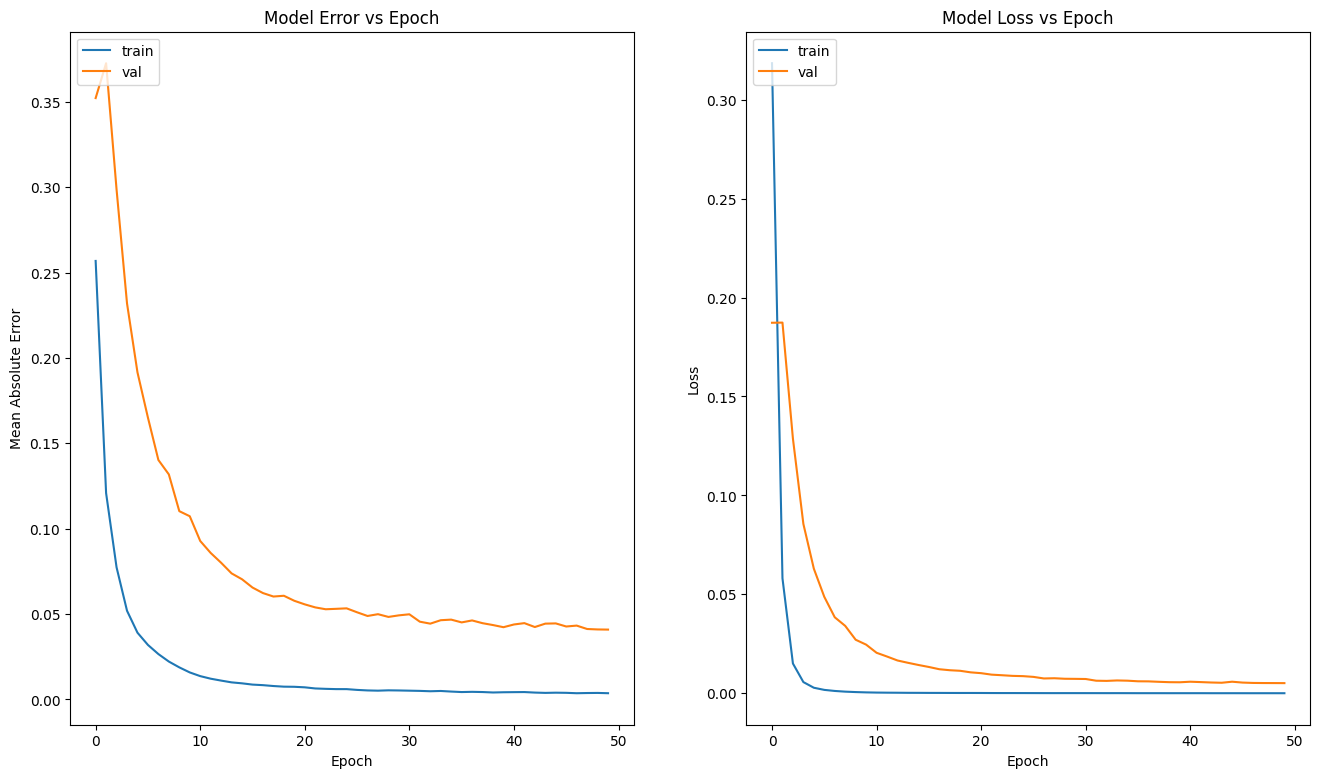

In [29]:
# Plot the training history
plot_training_history(models[lstm_model_name].history)

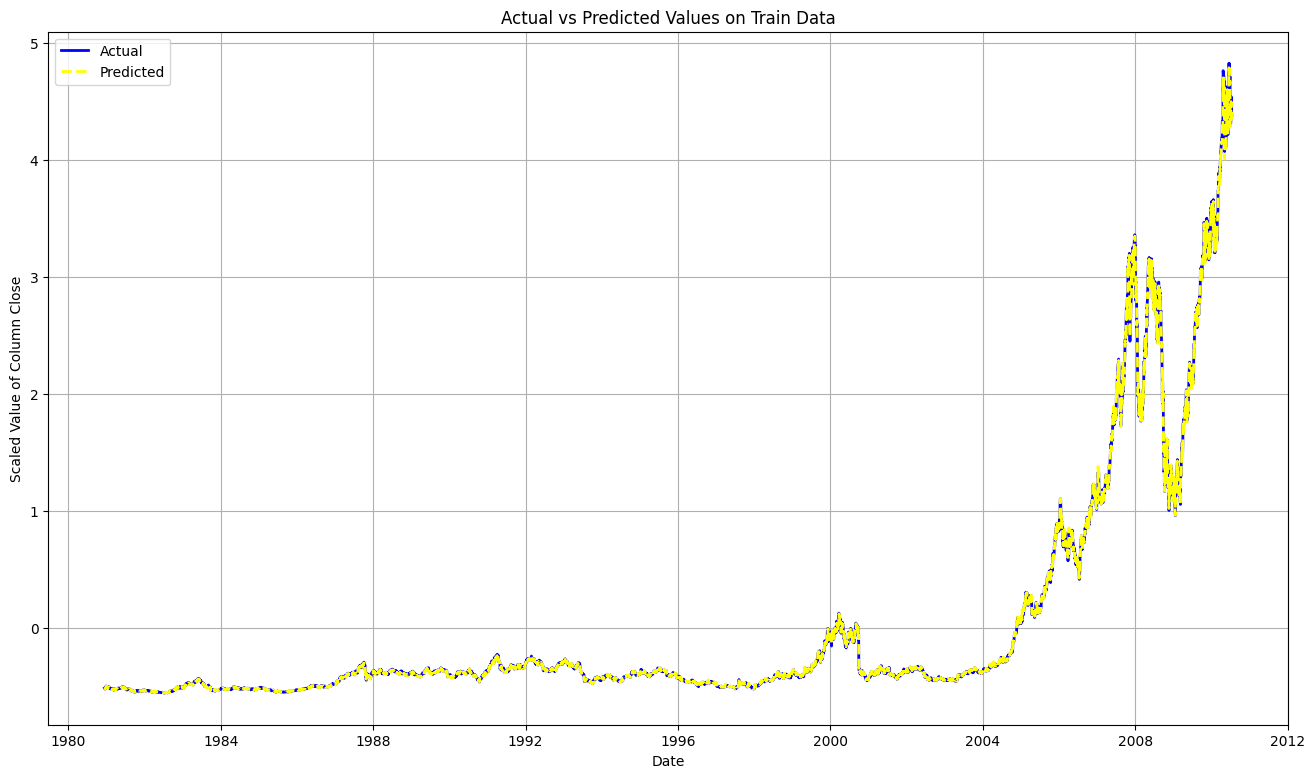

In [30]:
# Compare model's predictions with training labels
plot_values_comparison('Train', train_data['Date'], train_X, train_y, models[lstm_model_name].prediction_train)

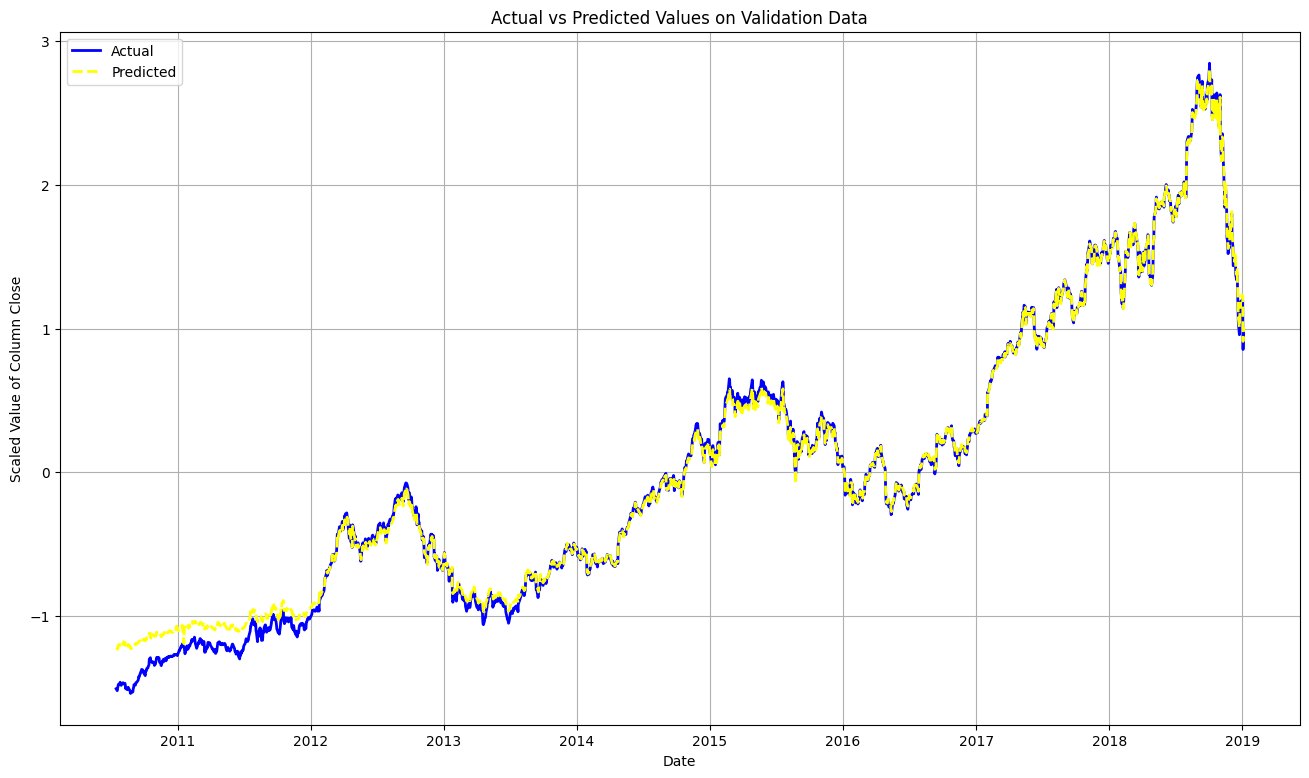

In [31]:
# Compare model's predictions with validation labels
plot_values_comparison('Validation', val_data['Date'], val_X, val_y, models[lstm_model_name].prediction_val)

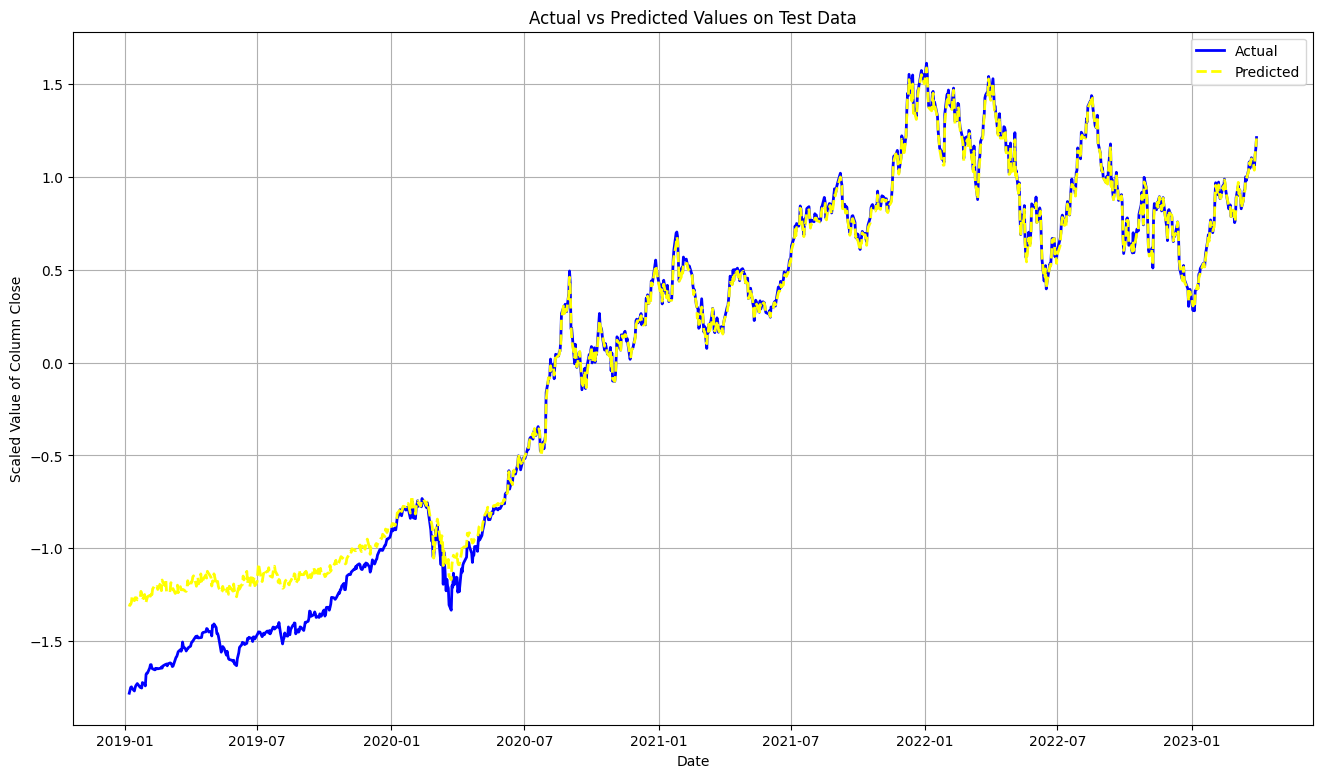

In [32]:
# Compare model's predictions with test labels
plot_values_comparison('Test', test_data['Date'], test_X, test_y, models[lstm_model_name].prediction_test)

## Hybrid Quantum-Classical Model

### Quantum Depth-Infused Layer

In [33]:
def rotation_layer(qubits,
                   symbols: list[str],
                   rotation: cirq.Gate,
                   ) -> cirq.Circuit:
    '''Generates a variational quantum circuit on the given qubits that performs
        a given rotation with the angle denoted by the given symbols.

    Args:
        qubits: List of qubits to use in the layer.
        symbols: List of parameter names for the rotation angles.
        rotation: The rotation gate to apply (cirq.rx, cirq.ry, cirq.rz, etc.)

    Returns:
        A quantum circuit encoding a rotation layer on the given qubits.
    '''
    # Create empty circuit
    circuit = cirq.Circuit()

    # Apply parametrized X rotation gates on each qubit
    for i, q in enumerate(qubits):
        circuit.append(rotation(symbols[i])(q))

    # Return resulting circuit and list of symbols
    return circuit


def entangling_layer(qubits) -> cirq.Circuit:
    '''Generates a quantum circuit encoding an entangling layer on the given
        qubits.

    Args:
        qubits: List of qubits to use in the layer.

    Returns:
        A quantum circuit encoding an entangling layer on the given qubits.
    '''
    # Create empty circuit
    circuit = cirq.Circuit()

    # Apply CNOT gates arranged in a circule
    for i in range(len(qubits) - 1):
        circuit.append(cirq.CNOT(qubits[i], qubits[i + 1]))
    if len(qubits) > 2:
        # Only add last CNOT gate if there are more than 2 qubits
        circuit.append(cirq.CNOT(qubits[-1], qubits[0]))

    # Return resulting circuit
    return circuit


def QDI_circuit(qubits,
                preprocess_layers: int = 3,
                postprocess_layers: int = 3,
                preprocess_symbol: str = 'w_0',
                postprocess_symbol: str = 'w_1',
                angle_symbol: str = 'x',
                ) -> cirq.Circuit:
    '''Creates a quantum depth-infused layer.

    Args:
        qubits: List of qubits to use in the layer.
        preprocess_layers: Number of layers of variational quantum circuits in
            the preprocessing part of the QDI layer. Defaults to 3.
        postprocess_layers: Number of layers of variational quantum circuits in
            the postprocessing part of the QDI layer. Defaults to 3.
        preprocess_symbol: Name of parameter symbols of the preprocessing part
            of the QDI layer. Defaults to 'w_0'.
        postprocess_symbol: Name of parameter symbols of the postprocessing part
            of the QDI layer. Defaults to 'w_1'.
        angle_symbol: Name of parameter symbols of the angle encoding.
            Defaults to 'x'.

    Returns:
        A tuple containing the following:
        - A quantum circuit corresponding to the QDI layer.
        - Symbols for angle encoding parameters.
        - Symbols for pre- and post-angle encoding parameters.
    '''
    # Create empty circuit
    circuit = cirq.Circuit()

    # Create symbol lists
    angle_symbols = [sympy.Symbol(f'{angle_symbol}_{i}')
                     for i in range(len(qubits))]
    preprocess_symbols = [sympy.Symbol(f'{preprocess_symbol}_{j}_{i}')
                          for j in range(preprocess_layers)
                          for i in range(len(qubits))]
    postprocess_symbols = [sympy.Symbol(f'{postprocess_symbol}_{j}_{i}')
                           for j in range(postprocess_layers)
                           for i in range(len(qubits))]

    # Add pre-encoding circuits
    for layer in range(preprocess_layers):
        circuit += rotation_layer(qubits, preprocess_symbols, cirq.rx)
        circuit += entangling_layer(qubits)

    # Add angle encoding circuits
    circuit += rotation_layer(qubits, angle_symbols, cirq.rz)

    # Add post-encoding circuits
    for layer in range(postprocess_layers):
        circuit += rotation_layer(qubits, postprocess_symbols, cirq.rx)
        circuit += entangling_layer(qubits)

    return circuit, angle_symbols, preprocess_symbols + postprocess_symbols

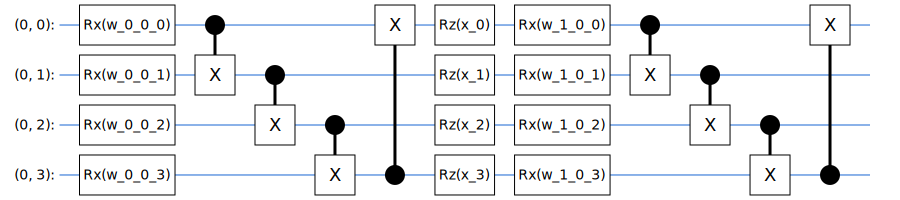

In [34]:
# Draw a smaller version of QDI circuit to check that generation works correctly
qubits = cirq.GridQubit.rect(1, 4)
SVGCircuit(QDI_circuit(qubits, preprocess_layers=1, postprocess_layers=1)[0])

In [35]:
class QDI(tf.keras.layers.Layer):
    '''Quantum Depth-Infused (QDI) layer implemented with keras and
    TensorFlow Quantum.

    Args:
        qubits: List of qubits to use in the layer.
        preprocess_layers: Number of layers of variational quantum circuits in
            the preprocessing part of the QDI layer. Defaults to 3.
        postprocess_layers: Number of layers of variational quantum circuits in
            the postprocessing part of the QDI layer. Defaults to 3.
        preprocess_symbol: Name of parameter symbols in the preprocessing part
            of the QDI layer. Defaults to 'w_0'.
        postprocess_symbol: Name of parameter symbols in the postprocessing part
            of the QDI layer. Defaults to 'w_1'.
        angle_symbol: Name of parameter symbols of the angle encoding.
            Defaults to 'x'.
        num_measurements: Number of measurements to perform. Defaults to 5000.
    '''

    def __init__(self,
                 qubits,
                 preprocess_layers: int = 3,
                 postprocess_layers: int = 3,
                 preprocess_symbol: str = 'w_0',
                 postprocess_symbol: str = 'w_1',
                 angle_symbol: str = 'x',
                 num_measurements: int = 5000,
                 **kwargs):
        # Initialize superclass with keyword arguments
        super(QDI, self).__init__(**kwargs)

        # Create QDI circuit
        self.circuit, input_symbols, param_symbols = QDI_circuit(
            qubits,
            preprocess_layers=preprocess_layers,
            postprocess_layers=postprocess_layers,
            preprocess_symbol=preprocess_symbol,
            postprocess_symbol=postprocess_symbol,
            angle_symbol=angle_symbol
        )

        # Create variables
        params_init = tf.random_uniform_initializer(minval=0.0, maxval=np.pi)
        self.params = tf.Variable(
            initial_value=params_init(shape=(1, len(param_symbols)),
                                      dtype='float32'),
            trainable=True,
        )

        # Make sure the list of symbols is in alphabetical order,
        # as ControlledPQC internally traverses them in that order,
        # otherwise there can be problems with training parameters
        symbols = [str(s) for s in param_symbols + input_symbols]
        assert(symbols == sorted(symbols))
        # todo: for some reason, despite this measure the training is still
        # buggy, but can succeed changing values of `preprocess_layers` and
        # `postprocess_layers` - reducing them to 1 and then increasing them
        # back to 3 seems to help

        # Define computation layer
        observables = [cirq.Y(q) for q in qubits]
        self.CPQC = tfq.layers.ControlledPQC(
            self.circuit, observables, repetitions=num_measurements
        )

        # Save empty circuit for later use
        self.empty_circuit = tfq.convert_to_tensor([cirq.Circuit()])

    def call(self, inputs):
        batch_size = tf.gather(tf.shape(inputs[0]), 0)
        tiled_circuit = tf.repeat(self.empty_circuit, repeats=batch_size)
        tiled_params = tf.tile(self.params, multiples=[batch_size, 1])
        tiled_inputs = tf.tile(inputs[0], multiples=[1, 1])
        joined_vars = tf.concat([tiled_params, tiled_inputs], axis=1)
        return self.CPQC([tiled_circuit, joined_vars])

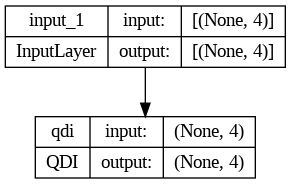

In [36]:
# Check that QDI layer maps `num_qubits` inputs into `num_qubits` outputs
input_tensor = tf.keras.Input(shape=(4, ),
                              dtype=tf.dtypes.float32)
qubits = cirq.GridQubit.rect(1, 4)
QDI_layer = QDI(qubits)([input_tensor])
model = tf.keras.Model(inputs=[input_tensor], outputs=QDI_layer)
tf.keras.utils.plot_model(model, show_shapes=True)

### Hybrid Quantum-Classical LSTM

In [41]:
class HQCLSTMCell(tf.keras.layers.Layer):
    '''Cell class for the hybrid quantum-classical LSTM layer.

    This class processes one step within the whole sequence input.

    Args:
        units: Dimensionality of the output space.
        n_q: Half of the number of qubits in the QDI layer. Defaults to 2.
        qdi_preprocess_layers: Number of layers of variational quantum circuits
            in the preprocessing part of the QDI layer. Defaults to 3.
        qdi_postprocess_layers: Number of layers of variational quantum circuits
            in the postprocessing part of the QDI layer. Defaults to 3.
        use_bias: Whether to use bias. Defaults to True.
    '''
    _num_cell = 0

    def __init__(self,
                 units: int,
                 n_q: int = 2,
                 qdi_preprocess_layers: int = 3,
                 qdi_postprocess_layers: int = 3,
                 use_bias: bool = True,
                 **kwargs):
        # Save cell's number (for defining unique symbols for QDI layer)
        self._num = HQCLSTMCell._num_cell
        HQCLSTMCell._num_cell += 1

        # Initialize superclass with keyword arguments
        super(HQCLSTMCell, self).__init__(**kwargs)

        # Save parameters
        self.units = units
        self.n_q = n_q
        self.qdi_preprocess_layers = qdi_preprocess_layers
        self.qdi_postprocess_layers = qdi_postprocess_layers
        self.use_bias = use_bias

    def build(self, input_shape) -> None:
        # Build superclass
        super().build(input_shape)

        # Define mapping of current input (feature) vector to input of QDI layer
        self.input_curr_to_QDI_input = [
            tf.keras.layers.Dense(self.n_q, use_bias=self.use_bias)
            for gate_idx in range(4)
        ]

        # Define mapping of previous hidden state to input of QDI layer
        self.hidden_state_to_QDI_input = [
            tf.keras.layers.Dense(self.n_q, use_bias=self.use_bias)
            for gate_idx in range(4)
        ]

        # Define action of QDI layer
        self.QDI_layer = [
            QDI(cirq.GridQubit.rect(1, 2 * self.n_q, top=gate_idx),
                preprocess_layers=self.qdi_preprocess_layers,
                postprocess_layers=self.qdi_postprocess_layers,
                preprocess_symbol=f'{self._num}_{gate_idx}_w_0',
                postprocess_symbol=f'{self._num}_{gate_idx}_w_1',
                angle_symbol=f'{self._num}_{gate_idx}_x')
            for gate_idx in range(4)
        ]

        # Define mapping from QDI layer output to LSTM gate values
        self.QDI_output_to_LSTM_gates = [
            tf.keras.layers.Dense(self.units, use_bias=self.use_bias)
            for gate_idx in range(4)
        ]

        # Mark cell as built
        self.built = True

    def call(self, inputs, states):
        '''Evaluates the cell for one time step.

        Args:
            inputs: A 2D tensor with shape `(batch_size, features)` containing
                input features at current time step.
            states: A 2D tensor with shape `(batch_size, units)` containing
                state at previous time step.

        Returns:
            Output and state at current time step.
        '''
        # Take previous hidden and carry states
        hidden_prev, carry_prev = states

        # Map input vector and hidden state to QDI layer input
        QDI_input = [
            tf.concat([self.input_curr_to_QDI_input[gate_idx](inputs),
                       self.hidden_state_to_QDI_input[gate_idx](hidden_prev)],
                      axis=1)
            for gate_idx in range(4)
        ]

        # Apply QDI layer
        QDI_output = [
            self.QDI_layer[gate_idx]([QDI_input[gate_idx]])
            for gate_idx in range(4)
        ]
        QDI_output = [
            tf.convert_to_tensor(QDI_output[gate_idx]) for gate_idx in range(4)
        ]

        # Map output of QDI layer to LSTM gate values
        forget_gate, input_gate, carry_gate, output_gate = [
            self.QDI_output_to_LSTM_gates[gate_idx](QDI_output[gate_idx])
            for gate_idx in range(4)
        ]

        # Compute carry and hidden state at current time step
        carry_curr = tf.nn.sigmoid(forget_gate) * carry_prev + \
                     tf.nn.sigmoid(input_gate) * tf.nn.tanh(carry_gate)
        hidden_curr = tf.nn.sigmoid(output_gate) * tf.nn.tanh(carry_curr)

        # Return output and state at current time step
        return hidden_curr, [hidden_curr, carry_curr]


@tf.keras.saving.register_keras_serializable()
class HQCLSTM(tf.keras.layers.Layer):
    '''Hybrid quantum-classical LSTM implemented with keras and
    TensorFlow Quantum.

    Args:
        units: Number of units in the LSTM layer.
        n_q: Half of the number of qubits in the QDI layer. Defaults to 2.
        qdi_preprocess_layers: Number of layers of variational quantum circuits
            in the preprocessing part of the QDI layer. Defaults to 3.
        qdi_postprocess_layers: Number of layers of variational quantum circuits
            in the postprocessing part of the QDI layer. Defaults to 3.
        return_state: Whether to return the entire hidden state instead of the
            last value. Defaults to False.
        return_sequences: Whether to return the output for each time step.
            Defaults to False.
        use_bias: Whether to use bias in the HQCLSTM layer. Defaults to True.
        input_shape: Shape of the input data.
    '''

    def __init__(self,
                 units: int,
                 n_q: int = 2,
                 qdi_preprocess_layers: int = 3,
                 qdi_postprocess_layers: int = 3,
                 return_state=False,
                 return_sequences=False,
                 use_bias: bool = True,
                 input_shape = None,
                 **kwargs):
        # Initialize superclass with keyword arguments
        super(HQCLSTM, self).__init__(input_shape=input_shape, **kwargs)

        # Create cell
        self.cell = HQCLSTMCell(
            units=units,
            n_q=n_q,
            qdi_preprocess_layers=qdi_preprocess_layers,
            qdi_postprocess_layers=qdi_postprocess_layers,
            use_bias=use_bias
        )

        # Save parameters
        self.units = units
        self.return_state = return_state
        self.return_sequences = return_sequences

    def call(self, inputs, **kwargs):
        '''Defines the computation performed by the HQLSTM layer.

        Args:
            inputs: A 3D tensor with shape `(batch, time_steps, features)`
                containing input features.

        Returns:
            Either output history or last output, depending on whether
            `self.return_squences` is True or False, respectively, and, if
            `self.return_state` is True, additionally returns state history.
        '''
        # Get batch size and number of time steps
        batch_size = tf.shape(inputs)[0]
        time_steps = tf.shape(inputs)[1]

        # Reshape inputs
        inputs = tf.transpose(inputs, [1, 0, 2])

        # Define initial state
        initial_state = tf.zeros((batch_size, self.units))
        state = [initial_state, initial_state]

        # Reserve space for outputs
        outputs = tf.TensorArray(tf.float32, size=time_steps)

        # Process sequence
        for time_step in tf.range(time_steps):
            output, state = self.cell(inputs[time_step], state)
            if self.return_sequences:
                outputs = outputs.write(time_step, state[0])

        # Return based on configuration
        output = tf.transpose(outputs.stack(), [1, 0, 2]) \
            if self.return_sequences else state[0]
        if self.return_state:
            return output, state
        return output

### Training and Evaluation

In [48]:
# Define parameters of our model
hqclstm_params = {
    'units': 3,
    'n_q': 1,
    'qdi_preprocess_layers': 1,
    'qdi_postprocess_layers': 1,
    'return_sequences': False,
}
hqclstm_max_epochs = 20
hqclstm_model_name = f'HQCLSTM_' + '_'.join(
    f'{param_val}' for param_val in hqclstm_params.values()
)

In [49]:
if LOAD_MODELS:
    # Load model state
    models[hqclstm_model_name] = ModelState().load(hqclstm_model_name, hqclstm_max_epochs)

    # Print model summary
    models[hqclstm_model_name].model.summary()
else:
    # Initialize model
    hqclstm_model = tf.keras.Sequential([
        HQCLSTM(**hqclstm_params, input_shape=(train_X.shape[1], 1)),
        tf.keras.layers.Dense(1),
    ])

    # Print model summary
    hqclstm_model.summary()

    # Compile model
    hqclstm_model.compile(optimizer='adam',
                          loss='mean_squared_error',
                          metrics=['mean_absolute_error'])

    # Add model to dictionary of models
    models[hqclstm_model_name] = ModelState(hqclstm_model_name, hqclstm_model)

    # Train model, saving progress after every epoch
    for epoch in range(0, hqclstm_max_epochs):
        # Train model
        models[hqclstm_model_name].train(1, train_X, train_y, val_X, val_y)

        # Compute model predictions
        models[hqclstm_model_name].predict(train_X, val_X, test_X)

        # Evaluate model on validation and training test
        models[hqclstm_model_name].evaluate(val_X, val_y, test_X, test_y)

        # Save model
        models[hqclstm_model_name].save()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hqclstm_5 (HQCLSTM)         (None, 3)                 76        
                                                                 
 dense_6 (Dense)             (None, 1)                 4         
                                                                 
Total params: 80 (320.00 Byte)
Trainable params: 80 (320.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
34/34 [==============================] - 16s 461ms/step - loss: 7.3939 - mean_absolute_error: 1.4068


In [50]:
# Output model performance
print(models[hqclstm_model_name].eval_results)

Evaluation results on validation dataset:
Loss: 3.8432703018188477
Mean absolute error: 0.8417918682098389

Evaluation results on test dataset:
Loss: 7.393882751464844
Mean absolute error: 1.4067531824111938
Mean squared error (MSE): 7.430902360517339
Root mean squared error (RMSE): 2.725968151046035
R-squared: -6.43787318824765



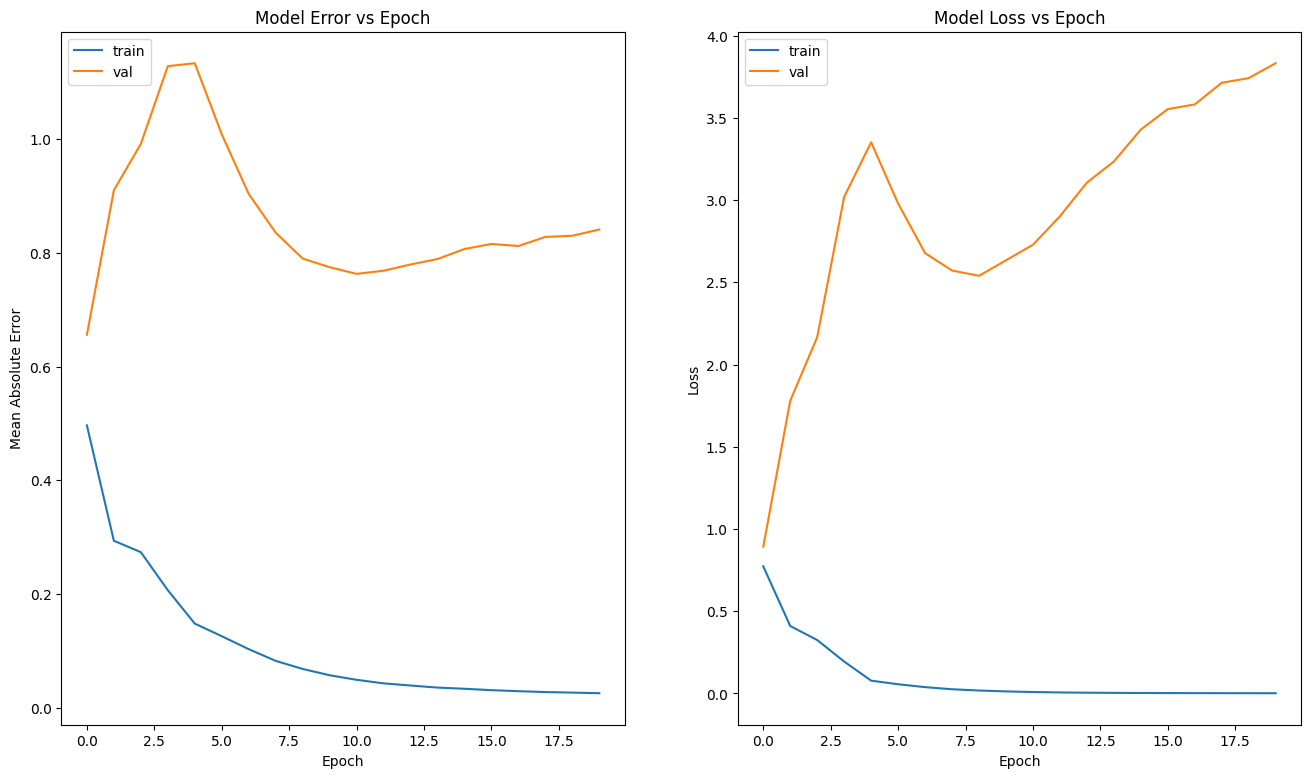

In [51]:
# Plot the training history
plot_training_history(models[hqclstm_model_name].history)

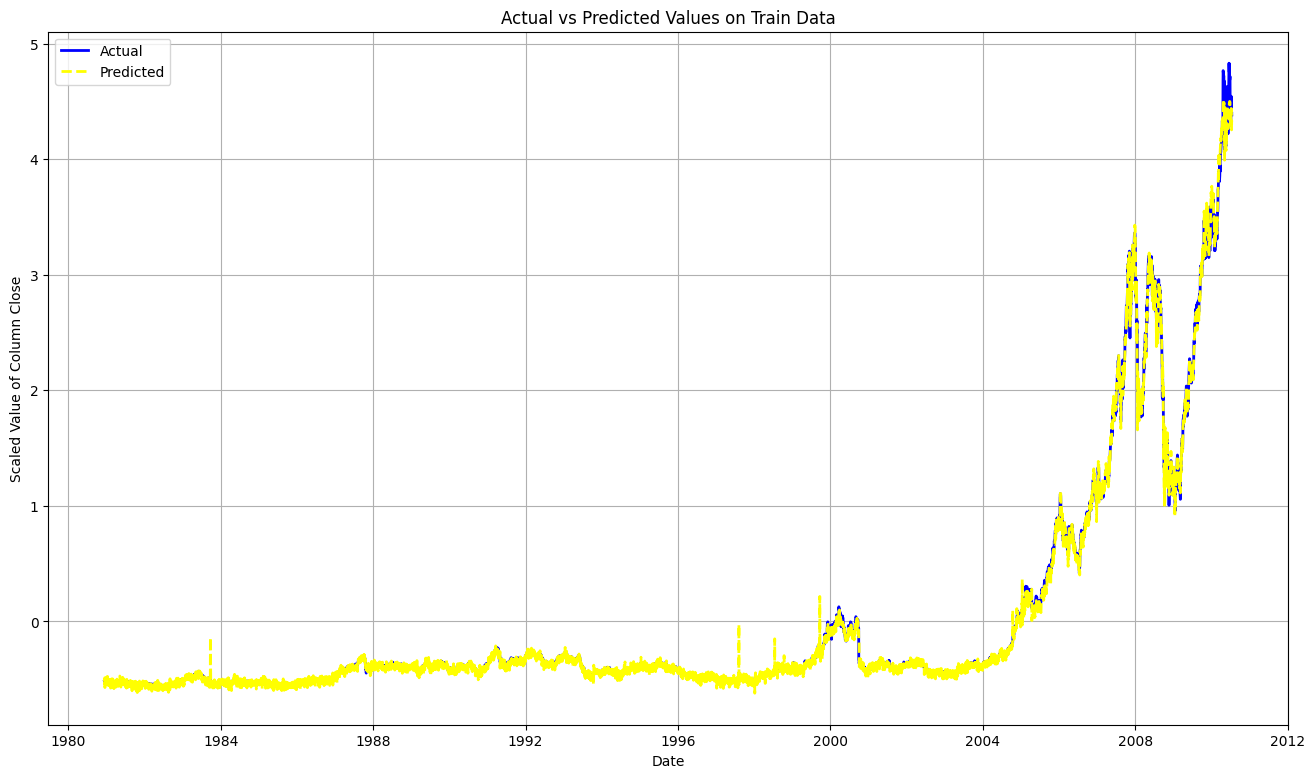

In [52]:
# Compare model's predictions with training labels
plot_values_comparison('Train', train_data['Date'], train_X, train_y, models[hqclstm_model_name].prediction_train)

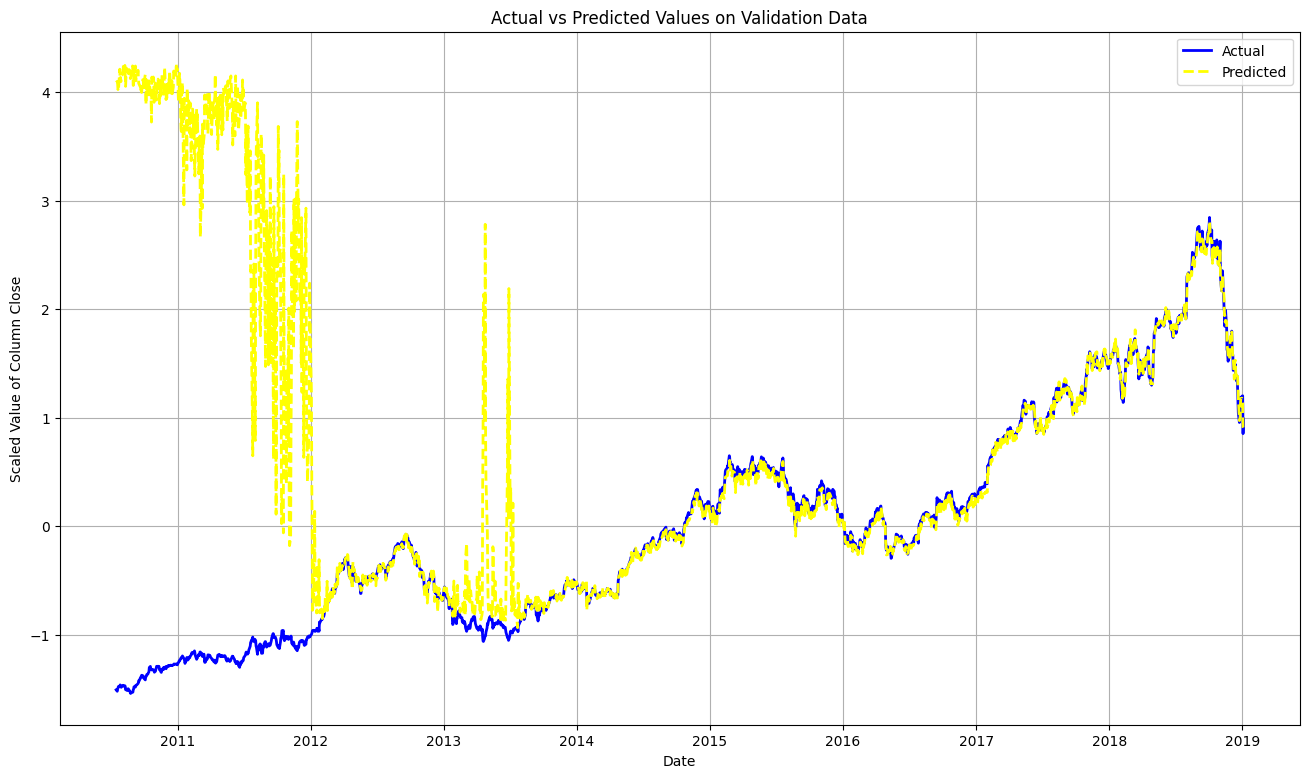

In [53]:
# Compare model's predictions with validation labels
plot_values_comparison('Validation', val_data['Date'], val_X, val_y, models[hqclstm_model_name].prediction_val)

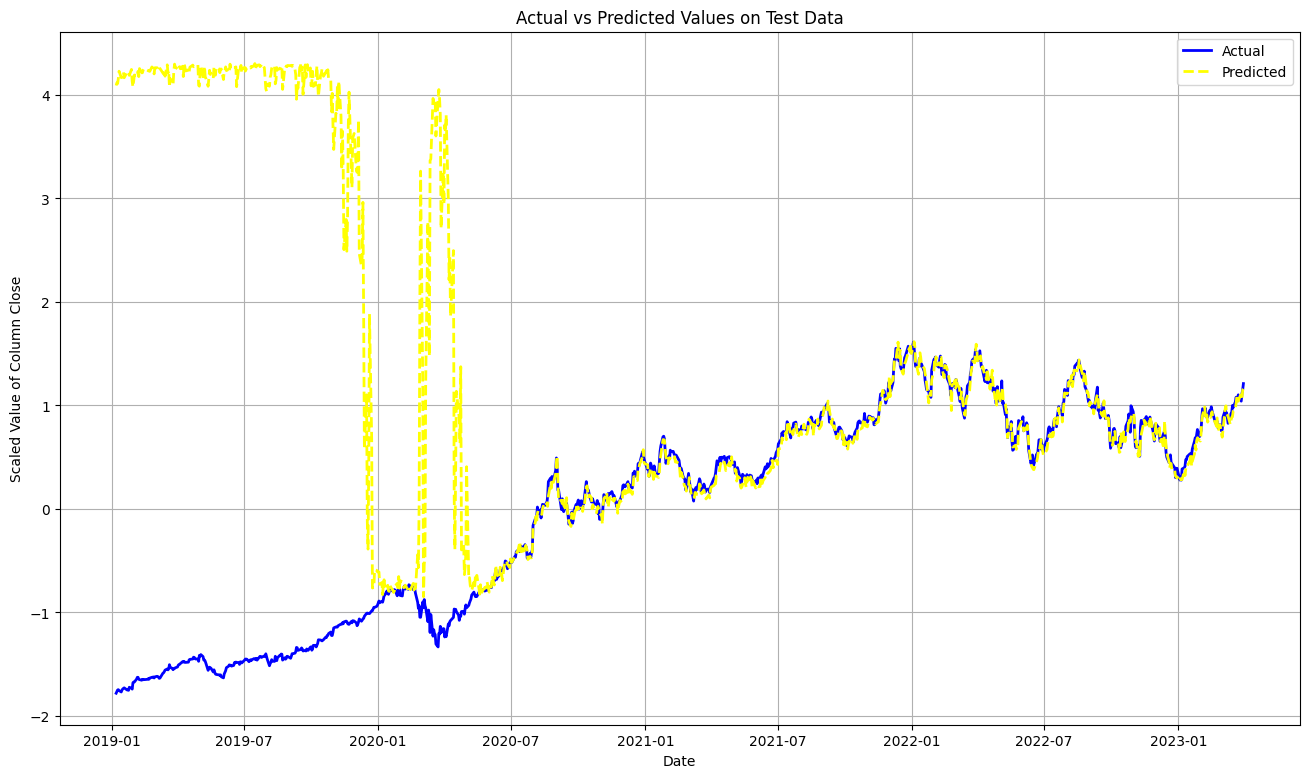

In [54]:
# Compare model's predictions with test labels
plot_values_comparison('Test', test_data['Date'], test_X, test_y, models[hqclstm_model_name].prediction_test)

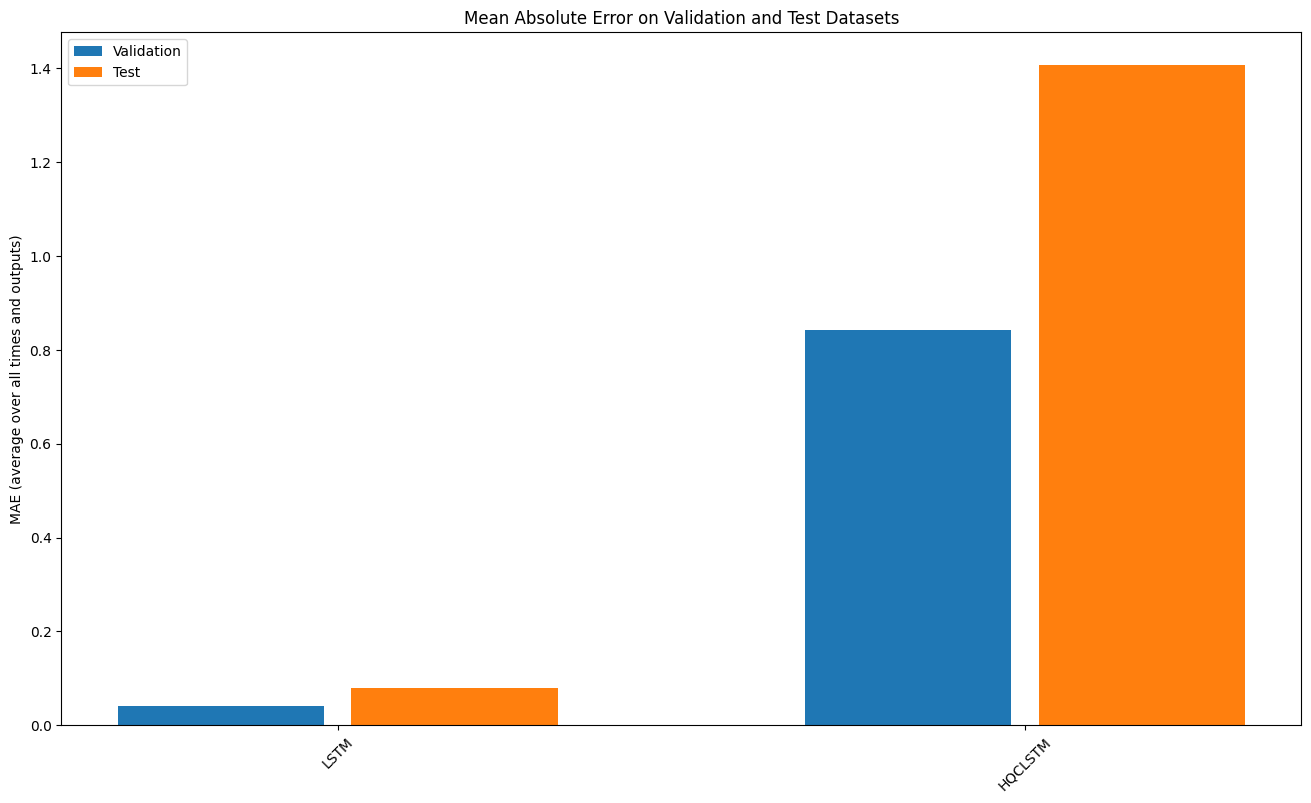

In [55]:
# Compare performance of classical and hybrid models
plot_evaluation_comparison({
    'LSTM': models[lstm_model_name].eval_results,
    'HQCLSTM': models[hqclstm_model_name].eval_results,
})

# Potential Improvements

## Dataset and Data Analysis
    
- **Normalize data using moving averages.** Currently we perform simple normalization over the entire training set and the entire test set, which gives the models indirect information about future values of the feature vectors and, in case of training, the target labels. With moving averages, the model would have absolutely no access (even indirect) to future values during training and evaluation, so it would be a "fairer" way to normalize the data.
- **Implement windowing.** Currently our models are essentially given the entire training set and they can only be predict the next target label. By implementing windowing we can generalize the models and have them make predictions several time steps in the future based on a limited context window.
- **Use growth rates as the features and the target label.** Currently we use the original input features and target labels. In particular, we do not introduce use any functions of the input data as new features and rely on the models to find a good mapping to some intermediate representation. In financial sciences, growth rates are often utilized in addition to or even in place of the original values. As we can see from the boxplots, the growthrates seem to be better behaved (read: seem to have a nicer distribution) than the original features. Thus, there is a good chance that utilizing growthrates might increase the predictive power of our models.
- **Apply our techniques to other datasets.** The current dataset (Apple Stock Price from 1980-2021) has relatively few entries and features. This might lead to classical models already being sufficient for obtaining highly accurate predictions, and the advantage of QML might not be seen. It might be a good idea to examine datasets with more complicated patterns, e.g., bigger financial datasets or datasets related to physical or even quantum phenomena, where hybrid quantum-classical methods are more likely to prove advantageous. For example, the Bitcoin Historical Data and the Electricity Transformer Dataset seem like good candidates.

## Classical Model

- **Optimize hyperparameters of the LSTM model.** We set the hyperparameters of the classical model to get a comparable number of trainable coefficients to our quantum model. Tuning the hyperparameters of the model could lead to better accuracy of predictions.
- **Try other models.** We focused on the LSTM model as the natural counterpart to HQCLSTM. Nevertheless, there is lots of room for experimentation with the model's architecture, including both simpler approaches, such as a feed-forward classical network, and more complicated ones, such as LSTM with residual connections. Adjusting algorithms used for optimizing the parameters of the model could also lead to better convergence rate and prediction accuracy.

## Hybrid Quantum-Classical Model

- **Optimize hyperparameters of the HQCLSTM model.** We set the hyperparameters of the hybrid quantum-classical model largely following the paper "Photovoltaic power forecasting using quantum machine learning", which introduced the HQCLSTM architecture. Tuning the hyperparameters of the model could lead to better accuracy of predictions.
- **Try other models.** We focused on implementing the HQCLSTM model, as it seemed like a natural generalization of the LSTM model with sufficient expressive power to make fairly accurate predictions on our data. Nevertheless, there is lots of room for experimentation with the model's architecture, including both simpler approaches, such as a feed-forward network with a quantum layer, and more complicated ones, such as introducing additional quantum layers to the HQCLSTM model. Additionally, one could investigate various algorithms for optimizing the parameters of the variational quantum circuits in these models, which could also improve the convergence rate and the prediction accuracy.


# References

## Datasets

- [Apple Stock Price from 1980-2021](https://www.kaggle.com/datasets/meetnagadia/apple-stock-price-from-19802021)
- [Bitcoin Historical Data](https://www.kaggle.com/datasets/mczielinski/bitcoin-historical-data) (unused for now, could be a good choice to experiment with)
- [Electricity Transformer Dataset](https://paperswithcode.com/dataset/ett) (unused for now, could be a good choice to experiment with)

## Libraries

- [TensorFlow](https://www.tensorflow.org/)
    - [Time Series Forecasting](https://www.tensorflow.org/tutorials/structured_data/time_series) tutorial, in particular the [RNN section](https://www.tensorflow.org/tutorials/structured_data/time_series#recurrent_neural_network)
    - [Documentation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM) and [source code](https://github.com/keras-team/keras/blob/v3.3.3/keras/src/layers/rnn/lstm.py#L318-L669) of the LSTM layer
- [TensorFlow Quantum](https://www.tensorflow.org/quantum)
    - [Hello, Many Worlds](https://www.tensorflow.org/quantum/tutorials/hello_many_worlds) tutorial, in particular [Section 2](https://www.tensorflow.org/quantum/tutorials/hello_many_worlds#2_hybrid_quantum-classical_optimization).
    - [MNIST Classification](https://www.tensorflow.org/quantum/tutorials/mnist) tutorial, in particular [Section 2](https://www.tensorflow.org/quantum/tutorials/mnist#2_quantum_neural_network)
    - [Quantum Reinforcement Learning](https://www.tensorflow.org/quantum/tutorials/quantum_reinforcement_learning) tutorial, in particular [Section 1](https://www.tensorflow.org/quantum/tutorials/quantum_reinforcement_learning#1_build_a_pqc_with_data_re-uploading)
    - Documentation on [ControlledPQC](https://www.tensorflow.org/quantum/api_docs/python/tfq/layers/ControlledPQC) and [PQC](https://www.tensorflow.org/quantum/api_docs/python/tfq/layers/PQC)
    - [Quantum Convolutional Neural Network](https://www.tensorflow.org/quantum/tutorials/qcnn) tutorial could serve as inspiration for a simpler model than HQCLSTM
- [Cirq](https://quantumai.google/cirq) documentation, in particular the [list of common gates](https://quantumai.google/cirq/build/gates?hl=en#common_gates) and references therein

## Research Papers

- Hybrid quantum-classical LSTM
    - [Photovoltaic power forecasting using quantum machine learning](https://arxiv.org/abs/2312.16379), in particular the HQLSTM architecture
    - [Hybrid quantum neural network for drug response prediction](https://arxiv.org/abs/2211.05777), in particular a different architecture for the quantum depth-infused (QDI) neural network layer shown in Figure 2
    - [Parametrized quantum policies for reinforcement learning](https://arxiv.org/abs/2103.05577), in particular the hybrid RL agent depicted in Figure 1
- Survey papers
    - [Comprehensive Survey of QML: From Data Analysis to Algorithmic Advancements](https://arxiv.org/abs/2501.09528) is an excellent survey on the current state-of-the-art
    - [Quantum deep neural networks for time series analysis](https://link.springer.com/article/10.1007/s11128-024-04404-y) is a survey of QML approaches specifically to time series
- [Quantum convolutional neural network based on variational quantum circuits](https://www.sciencedirect.com/science/article/pii/S0030401823007411)
- [Time Series Forecasting with Quantum Neural Networks](https://link.springer.com/chapter/10.1007/978-3-031-43085-5_53)
- [Classification with Quantum Neural Networks on Near Term Processors](https://arxiv.org/abs/1802.06002)

## Lecture Notes

- [MIT Computational Tutorial: An introduction to LSTMs in Tensorflow](https://cbmm.mit.edu/sites/default/files/learning-hub/BCS_LSTM_Lecture.pdf) is a solid practical introduction to LSTMs

## Popular Science Articles

- [Guide to Quantum ML for Data Scientists](https://postquantum.com/quantum-ai/quantum-machine-learning-qml/)